<a href="https://colab.research.google.com/github/srovins/kvasir_gi_images_classification/blob/main/combine_vgg_dn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load previously saved features


In [6]:
import pandas as pd
import numpy as np

In [11]:
vgg_features = np.array(pd.read_pickle("vgg_features.pkl"))
dn_features = np.array(pd.read_pickle("dn_features.pkl"))
vgg_features_val = np.array(pd.read_pickle("vgg_features_val.pkl"))
dn_features_val = np.array(pd.read_pickle("dn_features_val.pkl"))
vgg_features_test = np.array(pd.read_pickle("vgg_features_test.pkl"))
dn_features_test = np.array(pd.read_pickle("dn_features_test.pkl"))


# Combine features extracted using DenseNet-169 and VGG-16 models

In [12]:
# extract class labels
y_train = dn_features[:,-1]
y_val = dn_features_val[:,-1]
y_test = dn_features_test[:,-1]

In [13]:
dn_features_val = dn_features_val[:,:-1]
dn_features = dn_features[:,:-1]
dn_features_test = dn_features_test[:,:-1]

In [14]:
combined_features = np.concatenate ((dn_features, vgg_features), axis=1)
combined_features_val = np.concatenate ((dn_features_val, vgg_features_val), axis=1)
combined_features_test = np.concatenate ((dn_features_test, vgg_features_test), axis=1)

In [15]:
# 256 features from VGG16 + 256 features from DenseNet169
print ("combined_features.shape: ", combined_features.shape)
print ("combined_features_val.shape: ", combined_features_val.shape)
print ("combined_features_test.shape: ", combined_features_test.shape)

combined_features.shape:  (5760, 512)
combined_features_val.shape:  (1440, 512)
combined_features_test.shape:  (800, 512)


# Analyze features

In [17]:
import time
from sklearn.manifold import TSNE
import seaborn as sns
import pandas as pd

In [20]:
feat_cols = [ 'pixel'+str(i) for i in range(combined_features.shape[1]) ]
df = pd.DataFrame(combined_features,columns=feat_cols)
df['class'] = y_train
df['label'] = df['class'].apply(lambda i: str(i))
X, y = None, None
print('Size of the dataframe: {}'.format(df.shape))

Size of the dataframe: (5760, 514)


In [21]:
np.random.seed(42)
rndperm = np.random.permutation(df.shape[0])

In [22]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

In [23]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=5000)
tsne_results = tsne.fit_transform(df[feat_cols].values)
print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5760 samples in 0.296s...
[t-SNE] Computed neighbors for 5760 samples in 11.646s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5760
[t-SNE] Computed conditional probabilities for sample 2000 / 5760
[t-SNE] Computed conditional probabilities for sample 3000 / 5760
[t-SNE] Computed conditional probabilities for sample 4000 / 5760
[t-SNE] Computed conditional probabilities for sample 5000 / 5760
[t-SNE] Computed conditional probabilities for sample 5760 / 5760
[t-SNE] Mean sigma: 5.389929
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.094955
[t-SNE] KL divergence after 5000 iterations: 1.186911
t-SNE done! Time elapsed: 190.31714010238647 seconds


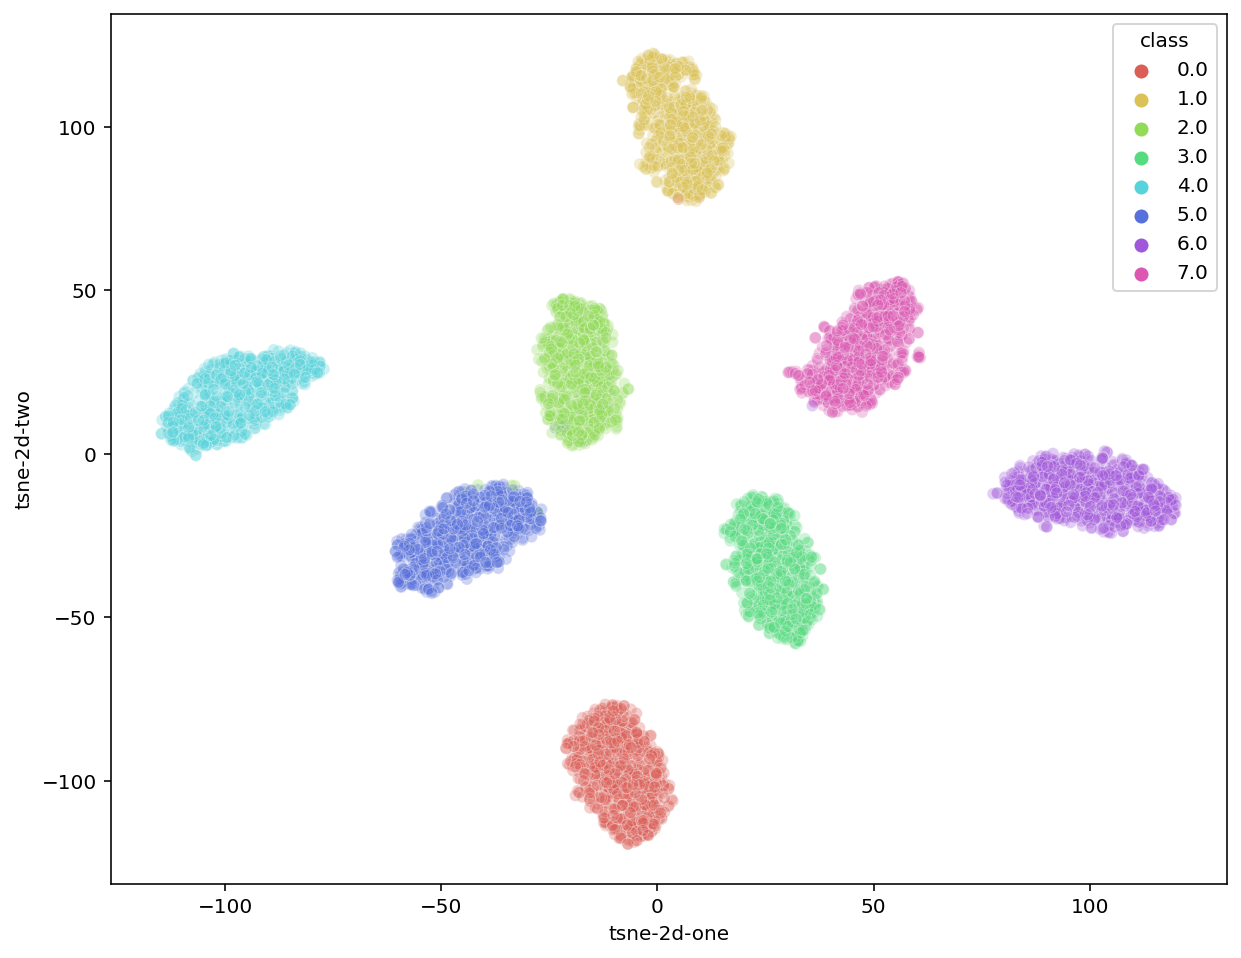

In [24]:
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
plt.figure(figsize=(10,8))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="class",
    palette=sns.color_palette("hls", 8),
    data=df,
    legend="full",
    alpha=0.3
)

# Logistic Regression Classifier

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

In [27]:
lr = LogisticRegression(max_iter=10000)

In [28]:
combined_features_all = np.concatenate((combined_features, combined_features_val))
y_train_all = np.concatenate((y_train, y_val))

In [29]:
combined_features_all.shape

(7200, 512)

In [30]:
y_train_all.shape

(7200,)

In [31]:
lr.fit(combined_features, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=10000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
from sklearn.metrics import accuracy_score

# training set accuracy
y_pred = lr.predict(combined_features_test)
accuracy_score( y_test, y_pred)

0.93625

In [33]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

In [34]:
precision_score(y_test, y_pred, average="weighted")

0.9364417978729953

In [35]:
recall_score(y_test, y_pred, average="weighted")

0.93625

In [41]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

In [42]:
cm

array([[ 98,   2,   0,   0,   0,   0,   0,   0],
       [  6,  94,   0,   0,   0,   0,   0,   0],
       [  0,   0,  86,   0,   1,  12,   1,   0],
       [  0,   0,   0,  98,   0,   0,   1,   1],
       [  0,   0,   0,   0, 100,   0,   0,   0],
       [  0,   0,  14,   0,   0,  86,   0,   0],
       [  0,   0,   1,   1,   0,   0,  94,   4],
       [  0,   0,   1,   1,   1,   0,   4,  93]])

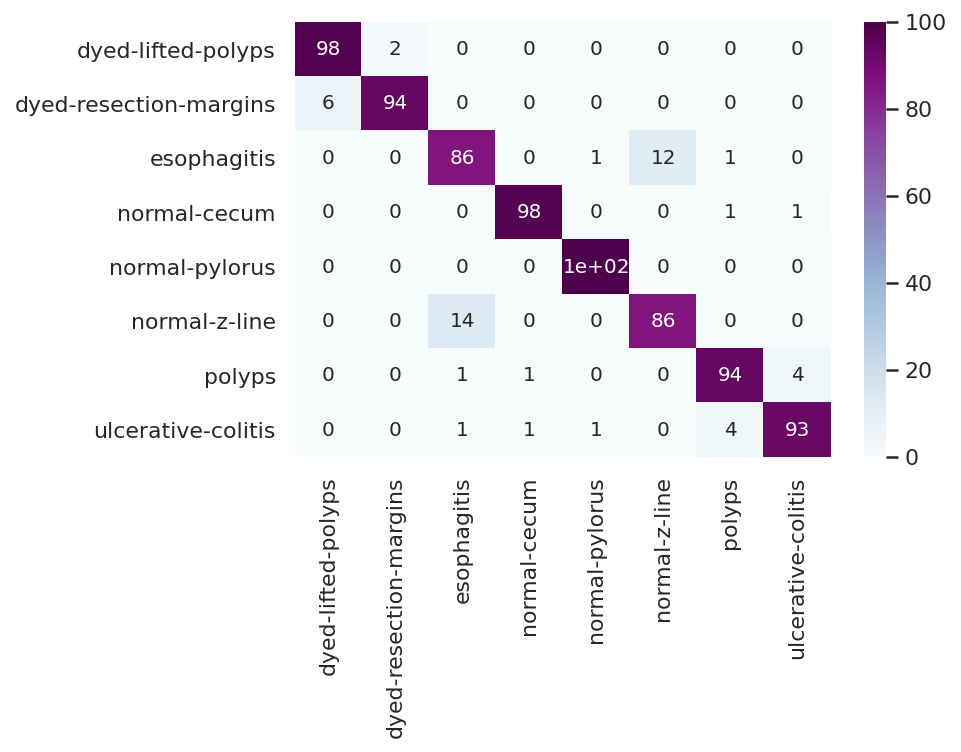

In [40]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
class_names = ['dyed-lifted-polyps', 'dyed-resection-margins', 'esophagitis', 'normal-cecum', 'normal-pylorus', 'normal-z-line', 'polyps', 'ulcerative-colitis']
df_cm = pd.DataFrame(cm, columns=class_names, index=class_names)
# plt.figure(figsize=(10,7))
sn.set(font_scale=1) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 10}, cmap="BuPu") # font size

plt.show()

# Other Classifiers (DT, KNN, and MLP)

In [43]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier

In [44]:
mlp = MLPClassifier()
mlp.fit(combined_features, y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [45]:
dt = DecisionTreeClassifier()
dt.fit(combined_features, y_train)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [46]:
neigh = KNeighborsClassifier(n_neighbors=20)
neigh.fit(combined_features, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=20, p=2,
                     weights='uniform')

In [47]:
pred_test1 = neigh.predict(combined_features_test)

In [48]:
pred_test2 = dt.predict(combined_features_test)

In [49]:
pred_test3 = mlp.predict(combined_features_test)

In [53]:
accuracy_score(y_test, pred_test1) # KNeighborsClassifier accuracy

0.93125

In [54]:
accuracy_score(y_test, pred_test2) # DecisionTreeClassifier accuracy

0.91625

In [55]:
accuracy_score(y_test, pred_test3) # MLP classifier accuracy

0.9325